# Uncertainty-aware Deep Learning with SNGP

### Author: Nimish Sanghi https://github.com/nsanghi

In this notebook we will use [JAX](https://jax.readthedocs.io/en/latest/), [Flax](https://flax.readthedocs.io/en/latest/), [Optax](https://optax.readthedocs.io/en/latest/) and [Edward2](https://github.com/google/edward2)

**JAX** - JAX is [Autograd](https://github.com/hips/autograd) and [XLA](https://www.tensorflow.org/xla), brought together for high-performance numerical computing and machine learning research. It provides composable transformations of Python+NumPy programs: differentiate, vectorize, parallelize, Just-In-Time compile to GPU/TPU, and more.

**Flax** - Flax is a neural network library and ecosystem for JAX that is designed for flexibility. Flax is in use by a growing community of researchers and engineers at Google who happily use Flax for their daily research.

**Optax** - Optax is a gradient processing and optimization library for JAX. It is designed to facilitate research by providing building blocks that can be recombined in custom ways in order to optimise parametric models such as, but not limited to, deep neural networks.

**Edward2** - Edward2 is a simple probabilistic programming language. It provides core utilities in deep learning ecosystems so that one can write models as probabilistic programs and manipulate a model's computation for flexible training and inference.



This notebook is based on: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/understanding/sngp.ipynb

In AI applications that are safety-critical, such as medical decision making and autonomous driving, or where the data is inherently noisy (for example, natural language understanding), it is important for a deep classifier to reliably quantify its uncertainty. The deep classifier should be able to be aware of its own limitations and when it should hand control over to the human experts. This tutorial shows how to improve a deep classifier's ability in quantifying uncertainty using a technique called **Spectral-normalized Neural Gaussian Process [SNGP](https://arxiv.org/abs/2006.10108)**.

The core idea of SNGP is to improve a deep classifier's _**distance awareness**_ by applying simple modifications to the network. A model's _distance awareness_ is a measure of how its predictive probability reflects the distance between the test example and the training data. This is a desirable property that is common for gold-standard probabilistic models (for example, the [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) with RBF kernels) but is lacking in models with deep neural networks. SNGP provides a simple way to inject this Gaussian-process behavior into a deep classifier while maintaining its predictive accuracy.

This tutorial implements a deep residual network (ResNet)-based SNGP model on [scikit-learn’s two moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset.

This tutorial illustrates the SNGP model on a toy 2D dataset. 

## About SNGP

SNGP is a simple approach to improve a deep classifier's uncertainty quality while maintaining a similar level of accuracy and latency. Given a deep residual network, SNGP makes two simple changes to the model:

* It applies spectral normalization to the hidden residual layers.
* It replaces the Dense output layer with a Gaussian process layer.

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


Compared to other uncertainty approaches (such as Monte Carlo dropout or Deep ensemble), SNGP has several advantages:

* It works for a wide range of state-of-the-art residual-based architectures (for example, (Wide) ResNet, DenseNet, or BERT).
* It is a single-model method—it does not rely on ensemble averaging). Therefore, SNGP has a similar level of latency as a single deterministic network, and can be scaled easily to large datasets like [ImageNet](https://github.com/google/uncertainty-baselines/tree/main/baselines/imagenet) and [Jigsaw Toxic Comments classification](https://github.com/google/uncertainty-baselines/tree/main/baselines/toxic_comments)
* It has strong out-of-domain detection performance due to the _distance-awareness_ property.

The downsides of this method are:

* The predictive uncertainty of SNGP is computed using the [Laplace approximation](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf). Therefore, theoretically, the posterior uncertainty of SNGP is different from that of an exact Gaussian process.

* SNGP training needs a covariance reset step at the beginning of a new epoch. This can add a tiny amount of extra complexity to a training pipeline. This tutorial shows a simple way to implement this using direct update of `state` of the model.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import jax
import jax.numpy as jnp
import numpy as np

try:
    import sklearn.datasets
except ModuleNotFoundError:
    %pip install -qq -U scikit-learn
    import sklearn.datasets

try:
    import flax
    import flax.linen as nn
    from flax.training import train_state
except ModuleNotFoundError:
    %pip install -qq -U flax
    import flax
    import flax.linen as nn
    from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq -U optax
    import optax

try:
    import edward2.jax as ed
except ModuleNotFoundError:
    %pip install -qq -U "git+https://github.com/google/edward2.git#egg=edward2"
    import edward2.jax as ed

     |████████████████████████████████| 197 kB 25.6 MB/s 
     |████████████████████████████████| 596 kB 66.3 MB/s 
     |████████████████████████████████| 217 kB 73.8 MB/s 
     |████████████████████████████████| 140 kB 75.7 MB/s 
     |████████████████████████████████| 51 kB 8.3 MB/s 
     |████████████████████████████████| 72 kB 713 kB/s 


Define visualization macros

In [2]:
plt.rcParams["figure.dpi"] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(
    vmin=0,
    vmax=1,
)
DEFAULT_N_GRID = 100

## The two moon dataset

Create the training and evaluation datasets from the [scikit-learn two moon dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [3]:
def make_training_data(sample_size=500):
    """Create two moon training dataset."""
    train_examples, train_labels = sklearn.datasets.make_moons(n_samples=2 * sample_size, noise=0.1)

    # Adjust data position slightly.
    train_examples[train_labels == 0] += [-0.1, 0.2]
    train_examples[train_labels == 1] += [0.1, -0.2]

    return train_examples, train_labels

Evaluate the model's predictive behavior over the entire 2D input space.

In [4]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
    """Create a mesh grid in 2D space."""
    # testing data (mesh grid over data space)
    x = np.linspace(x_range[0], x_range[1], n_grid)
    y = np.linspace(y_range[0], y_range[1], n_grid)
    xv, yv = np.meshgrid(x, y)
    return np.stack([xv.flatten(), yv.flatten()], axis=-1)

To evaluate model uncertainty, add an out-of-domain (OOD) dataset that belongs to a third class. The model never observes these OOD examples during training.

In [5]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
    return np.random.multivariate_normal(means, cov=np.diag(vars), size=sample_size)

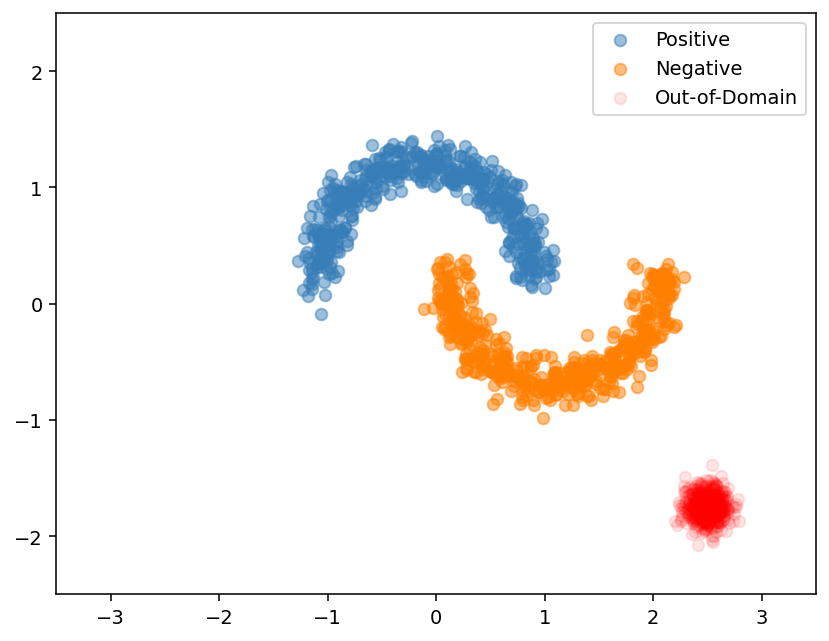

In [6]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

Here, the blue and orange represent the positive and negative classes, and the red represents the OOD data. A model that quantifies the uncertainty well is expected to be confident when close to training data  (i.e., $p(x_{test})$ close to 0 or 1), and be uncertain when far away from the training data regions  (i.e., $p(x_{test})$ close to 0.5).

## The deterministic model

### Define model

Start from the (baseline) deterministic model: a multi-layer residual network (ResNet) with dropout regularization.

In [7]:
class DeepResNet(nn.Module):
    num_classes: int
    num_layers: int = 3
    num_hidden: int = 128
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, inputs, train):
        # ResNet
        x = inputs
        hidden = nn.Dense(self.num_hidden, name="input_layer")(x)
        hidden = jax.lax.stop_gradient(hidden)
        for i in range(self.num_layers):
            resid = nn.Dense(self.num_hidden, name=f"dense_layers_{i}")(hidden)
            resid = nn.relu(resid)
            resid = nn.Dropout(self.dropout_rate)(resid, deterministic=not train)
            hidden += resid
        out = nn.Dense(self.num_classes, name="classifier")(hidden)
        return out

This tutorial uses a six-layer ResNet with 128 hidden units.

In [8]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)

### Define Loss and metrics

In [9]:
def cross_entropy_loss(*, logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=2)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()


def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

### Create train state

A common pattern in Flax is to create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state.

In [10]:
def create_train_state(rng, learning_rate, model):
    """Creates initial `TrainState`."""
    # resnet_model = DeepResNet(**resnet_config)
    params = model.init(rng, jnp.ones([1, 2]), train=True)["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

### Train Step

A function that:

- Evaluates the neural network given the parameters and a batch of input images with the `Module.apply` method.

- Computes the `cross_entropy_loss` loss function.

- Evaluates the loss function and its gradient using `jax.value_and_grad`.

- Applies a pytree of gradients to the optimizer to update the model’s parameters.

- Computes the metrics using `compute_metrics` (defined earlier).

Use JAX’s `@jit` decorator to trace the entire `train_step` function and just-in-time compile it with XLA into fused device operations that run faster and more efficiently on hardware accelerators.



In [11]:
@jax.jit
def train_step(state, batch, rng):
    """Train for a single step."""

    def loss_fn(params):
        logits = state.apply_fn({"params": params}, batch["input"], train=True, rngs={"dropout": rng})
        loss = cross_entropy_loss(logits=logits, labels=batch["label"])
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch["label"])
    return state, metrics


@jax.jit
def get_prob(state, batch):
    logits = state.apply_fn({"params": state.params}, batch, train=False)
    probs = nn.softmax(logits)
    return probs

### Train Function


In [12]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds["input"])
    steps_per_epoch = train_ds_size // batch_size

    rng, dropout_rng = jax.random.split(rng)
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        dropout_rng, sub_rng = jax.random.split(dropout_rng)
        batch = {"input": train_ds["input"][perm, ...], "label": train_ds["label"][perm]}
        state, metrics = train_step(state, batch, sub_rng)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    print(
        "train epoch: %d, loss: %.4f, accuracy: %.2f"
        % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100)
    )

    return state

### Initialize the state


In [13]:
rng = jax.random.PRNGKey(0)
rng, params_rng, dropout_rng = jax.random.split(rng, num=3)
resnet_model = DeepResNet(**resnet_config)
init_rngs = {"params": params_rng, "dropout": dropout_rng}

learning_rate = 1e-4
state = create_train_state(init_rngs, learning_rate, resnet_model)
del params_rng, dropout_rng, init_rngs

### Train the model

In [14]:
num_epochs = 100
batch_size = 128

train_ds = {"input": train_examples, "label": train_labels}

for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng)

train epoch: 1, loss: 1.9976, accuracy: 55.69
train epoch: 2, loss: 0.3985, accuracy: 83.15
train epoch: 3, loss: 0.1886, accuracy: 91.96
train epoch: 4, loss: 0.1409, accuracy: 93.30
train epoch: 5, loss: 0.1274, accuracy: 94.64
train epoch: 6, loss: 0.1433, accuracy: 93.19
train epoch: 7, loss: 0.1284, accuracy: 93.42
train epoch: 8, loss: 0.1283, accuracy: 93.86
train epoch: 9, loss: 0.1235, accuracy: 94.20
train epoch: 10, loss: 0.1264, accuracy: 93.86
train epoch: 11, loss: 0.1167, accuracy: 94.42
train epoch: 12, loss: 0.1043, accuracy: 94.75
train epoch: 13, loss: 0.1098, accuracy: 94.87
train epoch: 14, loss: 0.1047, accuracy: 94.53
train epoch: 15, loss: 0.0914, accuracy: 95.20
train epoch: 16, loss: 0.0992, accuracy: 95.31
train epoch: 17, loss: 0.0956, accuracy: 94.98
train epoch: 18, loss: 0.1059, accuracy: 94.42
train epoch: 19, loss: 0.0939, accuracy: 95.09
train epoch: 20, loss: 0.1144, accuracy: 93.86
train epoch: 21, loss: 0.0872, accuracy: 94.87
train epoch: 22, loss:

### Visualize uncertainty

In [15]:
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
    """Visualizes the 2D uncertainty surface.

    For simplicity, assume these objects already exist in the memory:

        test_examples: Array of test examples, shape (num_test, 2).
        train_labels: Array of train labels, shape (num_train, ).
        train_examples: Array of train examples, shape (num_train, 2).

    Arguments:
        test_uncertainty: Array of uncertainty scores, shape (num_test,).
        ax: A matplotlib Axes object that specifies a matplotlib figure.
        cmap: A matplotlib colormap object specifying the palette of the
          predictive surface.

    Returns:
        pcm: A matplotlib PathCollection object that contains the palette
          information of the uncertainty plot.
    """
    # Normalize uncertainty for better visualization.
    test_uncertainty = test_uncertainty / np.max(test_uncertainty)

    # Set view limits.
    ax.set_ylim(DEFAULT_Y_RANGE)
    ax.set_xlim(DEFAULT_X_RANGE)

    # Plot normalized uncertainty surface.
    pcm = ax.imshow(
        np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
        cmap=cmap,
        origin="lower",
        extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
        vmin=DEFAULT_NORM.vmin,
        vmax=DEFAULT_NORM.vmax,
        interpolation="bicubic",
        aspect="auto",
    )

    # Plot training data.
    ax.scatter(train_examples[:, 0], train_examples[:, 1], c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
    ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

    return pcm

Now visualize the predictions of the deterministic model. First plot the class probability:
$$p(x) = softmax(logit(x))$$

In [16]:
resnet_probs = get_prob(state, test_examples)
resnet_probs_0 = resnet_probs[:, 0]  # Take the probability for class 0.

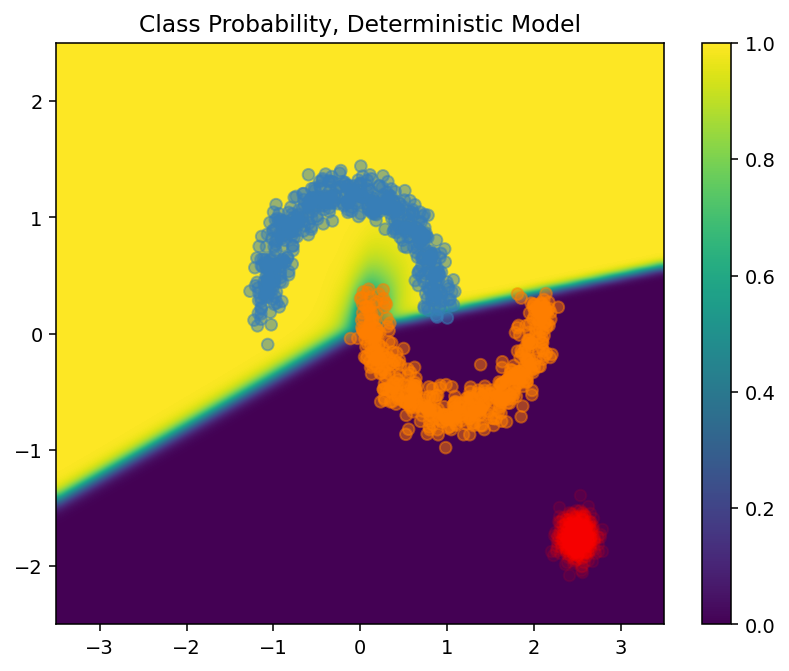

In [17]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs_0, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

In this plot, the yellow and purple are the predictive probabilities for the two classes. The deterministic model did a good job in classifying the two known classes—blue and orange—with a nonlinear decision boundary. However, it is not **distance-aware**, and classified the never-observed red out-of-domain (OOD) examples confidently as the orange class.

Visualize the model uncertainty by computing the [predictive variance](https://en.wikipedia.org/wiki/Bernoulli_distribution#Variance):
$$var(x) = p(x) * (1 - p(x))$$

In [18]:
resnet_uncertainty = resnet_probs_0 * (1 - resnet_probs_0)

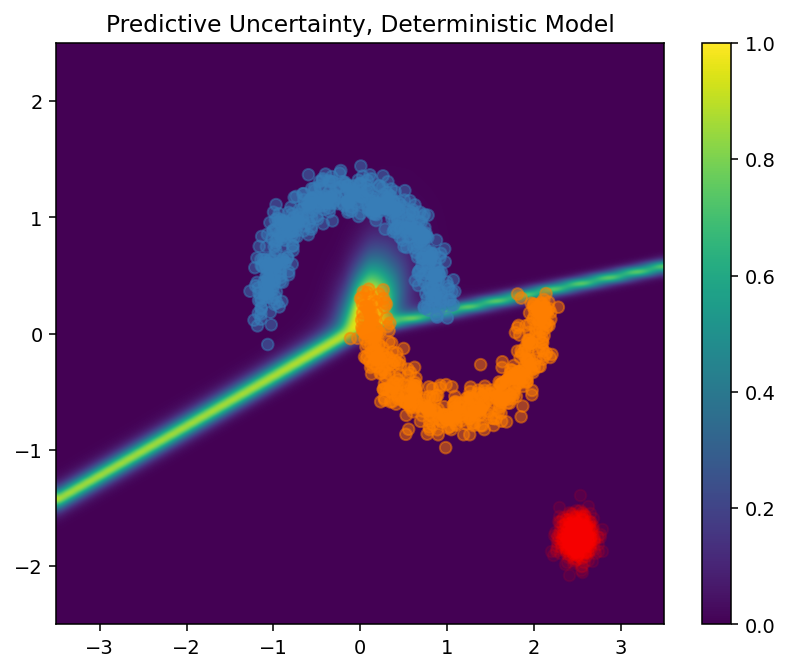

In [19]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

In this plot, the yellow indicates high uncertainty, and the purple indicates low uncertainty. A deterministic ResNet's uncertainty depends only on the test examples' distance from the decision boundary. This leads the model to be over-confident when out of the training domain. The next section shows how SNGP behaves differently on this dataset.

## The SNGP model

### Define SNGP model

Let's now implement the SNGP model. Both the SNGP components, `SpectralNormalization` and `RandomFeatureGaussianProcess`, are available in [Edward2](https://github.com/google/edward2). 

>![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)

Let's inspect these two components in more detail. 

#### `SpectralNormalization` wrapper

[`SpectralNormalization`](https://github.com/google/edward2/blob/main/edward2/jax/nn/normalization.py) is a Jax layer wrapper in Edward2 library. It can be applied to an existing Dense layer like this:

In [20]:
dense = nn.Dense(features=10)
dense = ed.nn.SpectralNormalization(dense, norm_multiplier=0.9)

Spectral normalization regularizes the hidden weight $W$ by gradually guiding its spectral norm (that is, the largest eigenvalue of $W$) toward the target value `norm_multiplier`).

Note: Usually it is preferable to set `norm_multiplier` to a value smaller than 1. However in practice, it can be also relaxed to a larger value to ensure the deep network has enough expressive power.

#### The Gaussian Process (GP) layer

[`RandomFeatureGaussianProcess`](https://github.com/google/edward2/blob/main/edward2/jax/nn/random_feature.py) implements a [random-feature based approximation](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) to a Gaussian process model that is end-to-end trainable with a deep neural network. Under the hood, the Gaussian process layer implements a two-layer network:

$$logits(x) = \Phi(x) \beta, \quad \Phi(x)=\sqrt{\frac{2}{M}} * cos(Wx + b)$$

Here, $x$ is the input, and $W$ and $b$ are frozen weights initialized randomly from Gaussian and Uniform distributions, respectively. (Therefore, $\Phi(x)$ are called "random features".) $\beta$ is the learnable kernel weight similar to that of a Dense layer. 

In [21]:
batch_size = 32
hidden_features = 1024
num_classes = 10

In [22]:
hidden_kwargs = {"feature_scale": None}
covmat_kwargs = {"momentum": None}

gp_layer = ed.nn.RandomFeatureGaussianProcess(
    features=num_classes,
    hidden_features=hidden_features,
    normalize_input=False,
    hidden_kwargs=hidden_features,
    covmat_kwargs=covmat_kwargs,
)

The main parameters of the GP layers are:

* `features`: The dimension of the output logits.
* `num_inducing`: The dimension $M$ of the hidden weight $W$. Default to 1024.
* `normalize_input`: Whether to apply layer normalization to the input $x$.
* `feature_scale`: Defined in `hidden_kwargs`. Use `None` to apply the scale $\sqrt{2/M}$ to the hidden output.
* `momentum`: Defined in `covmat_kwargs`. The momentum of the kernel weight update. Default to `None`.


Note: For a deep neural network that is sensitive to the learning rate (for example, ResNet-50 and ResNet-110), it is generally recommended to set `normalize_input=True` to stabilize training, and set `feature_scale=1.` to avoid the learning rate from being modified in unexpected ways when passing through the GP layer.

* `momentum` controls how the model covariance is computed. If set to a positive value (for example, `0.999`), the covariance matrix is computed using the momentum-based moving average update (similar to batch normalization). If set to `None`, the covariance matrix is updated without momentum.

Note: The momentum-based update method can be sensitive to batch size. Therefore it is generally recommended to set  `momentum=None` to compute the covariance exactly. For this to work properly, the covariance matrix estimator needs to be reset at the beginning of a new epoch in order to avoid counting the same data twice. 
`precision_matrix` is the state of the `RandomFeatureGaussianProcess` layer which we need to access and reset at the begining of each epoch. Function defined below `reset_precision_matrix(state)` resets the covariance matrix estimator to an Identity matrix.


Given a batch input with shape `(batch_size, input_dim)`, the GP layer returns a `logits` tensor (shape `(batch_size, num_classes)`) for prediction, and also  `covmat` tensor (shape `(batch_size,)` or `(batch_size, batch_size)`) which is the posterior covariance matrix of the batch logits.

#### The full SNGP model

Given the base class `DeepResNet`, the SNGP model can be implemented easily by  modifying the residual network's hidden and output layers.

In [23]:
class DeepResNetSNGP(nn.Module):
    num_classes: int
    num_layers: int = 3
    num_hidden: int = 128
    dropout_rate: float = 0.1
    spec_norm_bound: float = 0.9

    @nn.compact
    def __call__(self, inputs, training=False):
        # ResNet
        x = inputs
        hidden = nn.Dense(self.num_hidden, name="input_layer")(x)
        hidden = jax.lax.stop_gradient(hidden)
        for i in range(self.num_layers):
            resid = ed.nn.SpectralNormalization(nn.Dense(self.num_hidden), norm_multiplier=self.spec_norm_bound)(
                hidden, training=training
            )
            resid = nn.relu(resid)
            resid = nn.Dropout(self.dropout_rate)(resid, deterministic=not training)
            hidden += resid
        logits, covmat = ed.nn.RandomFeatureGaussianProcess(features=self.num_classes, normalize_input=False)(hidden)
        if not training:
            return logits, covmat
        return logits

### Update Step
Next we define `update_step` which implements a single step of model update. As we need to split the variables into two categories `state`, the internal state of the model and `params`, the model's parameters which are updated by the optimizer. `state` gets updated internally as part of the training step and are required to be extracted and fed back again at the next iteration. And `params` are the parameters that are updated by the optimizer.

In [24]:
def update_step(apply_fn, batch, opt_state, params, state, tx, rng):
    def loss_fn(params):
        logits, updated_state = apply_fn(
            {"params": params, **state},
            batch["input"],
            rngs={"dropout": rng},
            training=True,
            mutable=list(state.keys()),
        )
        loss = cross_entropy_loss(logits=logits, labels=batch["label"])
        metrics = compute_metrics(logits=logits, labels=batch["label"])
        return loss, (metrics, updated_state)

    (loss, (metrics, updated_state)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)  # Defined below.
    params = optax.apply_updates(params, updates)
    return metrics, opt_state, params, updated_state

### Training over one epoch
THe code below implements a single step through the full training data, shuffling the data at the beginning of each epoch.

In [25]:
def train_epoch_sngp(apply_fn, opt_state, params, state, tx, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds["input"])
    steps_per_epoch = train_ds_size // batch_size

    rng, dropout_rng = jax.random.split(rng)
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        dropout_rng, sub_rng = jax.random.split(dropout_rng)
        batch = {"input": train_ds["input"][perm, ...], "label": train_ds["label"][perm]}
        metrics, opt_state, params, state = update_step(apply_fn, batch, opt_state, params, state, tx, sub_rng)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    print(
        "train epoch: %d, loss: %.4f, accuracy: %.2f"
        % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100)
    )

    return opt_state, params, state

### Extract `precision_matrix` from model `state` and reset

Note: The momentum-based update method can be sensitive to batch size. Therefore it is generally recommended to set  `momentum=None` to compute the covariance exactly. For this to work properly, the covariance matrix estimator needs to be reset at the beginning of a new epoch in order to avoid counting the same data twice. 

`precision_matrix` is the state of the `RandomFeatureGaussianProcess` layer which we need to access and reset at the begining of each epoch. Function defined below `reset_precision_matrix(state)` resets the covariance matrix estimator to an Identity matrix.


In [26]:
def reset_precision_matrix(state):
    flat_state = flax.traverse_util.flatten_dict(state)
    precision_matrix = flat_state[
        ("laplace_covariance", "RandomFeatureGaussianProcess_0", "covmat_layer", "precision_matrix")
    ]
    num_hidden_features = precision_matrix.shape[0]
    flat_state[("laplace_covariance", "RandomFeatureGaussianProcess_0", "covmat_layer", "precision_matrix")] = jnp.eye(
        num_hidden_features, dtype=precision_matrix.dtype
    )
    state = flax.traverse_util.unflatten_dict(flat_state)
    state = flax.core.frozen_dict.freeze(state)
    return state

### Init and Train the model

In [27]:
rng = jax.random.PRNGKey(5)
rng, params_rng, dropout_rng = jax.random.split(rng, num=3)
sngp_model = DeepResNetSNGP(**resnet_config)
init_rngs = {"params": params_rng, "dropout": dropout_rng}
learning_rate = 1e-4

variables = sngp_model.init(init_rngs, jnp.ones([1, 2]), training=True)
# Split state and params (which are updated by optimizer).
state, params = variables.pop("params")
del variables  # Delete variables to avoid wasting resources
tx = optax.adam(learning_rate)
opt_state = tx.init(params)


num_epochs = 20
batch_size = 128

train_ds = {"input": train_examples, "label": train_labels}

for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute data during shuffling
    rng, input_rng = jax.random.split(rng)

    # reset precision matrix before each epoch. first epoch is already taken care in the `init` function.
    if epoch > 1:
        state = reset_precision_matrix(state)

    # Run an optimization step over a training batch
    opt_state, params, state = train_epoch_sngp(
        sngp_model.apply, opt_state, params, state, tx, train_ds, batch_size, epoch, input_rng
    )

train epoch: 1, loss: 0.5094, accuracy: 75.33
train epoch: 2, loss: 0.2971, accuracy: 89.73
train epoch: 3, loss: 0.1737, accuracy: 95.98
train epoch: 4, loss: 0.1211, accuracy: 97.77
train epoch: 5, loss: 0.0863, accuracy: 98.88
train epoch: 6, loss: 0.0660, accuracy: 99.00
train epoch: 7, loss: 0.0572, accuracy: 99.22
train epoch: 8, loss: 0.0470, accuracy: 99.55
train epoch: 9, loss: 0.0401, accuracy: 99.89
train epoch: 10, loss: 0.0344, accuracy: 100.00
train epoch: 11, loss: 0.0304, accuracy: 99.89
train epoch: 12, loss: 0.0286, accuracy: 99.89
train epoch: 13, loss: 0.0270, accuracy: 100.00
train epoch: 14, loss: 0.0225, accuracy: 100.00
train epoch: 15, loss: 0.0219, accuracy: 100.00
train epoch: 16, loss: 0.0212, accuracy: 99.89
train epoch: 17, loss: 0.0199, accuracy: 99.89
train epoch: 18, loss: 0.0181, accuracy: 100.00
train epoch: 19, loss: 0.0157, accuracy: 100.00
train epoch: 20, loss: 0.0160, accuracy: 99.89


### Visualize uncertainty
Next we define the model's prediction and evaluation functions, extracting the probability of the model's predictions.
In `get_prob_sngp`, we first compute the predictive logits and variances.

Next compute the posterior predictive probability. The classic method for computing the predictive probability of a probabilistic model is to use Monte Carlo sampling, i.e.,

$$E(p(x)) = \frac{1}{M} \sum_{m=1}^M logit_m(x), $$

where $M$ is the sample size, and $logit_m(x)$ are random samples from the SNGP posterior $MultivariateNormal$(`sngp_logits`,`sngp_covmat`). However, this approach can be slow for latency-sensitive applications such as autonomous driving or real-time bidding. Instead, you can approximate $E(p(x))$ using the [mean-field method](https://arxiv.org/abs/2006.07584):

$$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt{1+ \lambda * \sigma^2(x)}})$$

where $\sigma^2(x)$ is the SNGP variance, and $\lambda$ is often chosen as $\pi/8$ or $3/\pi^2$.

Note: Instead of fixing $\lambda$ to a fixed value, you can also treat it as a hyperparameter, and tune it to optimize the model's calibration performance. This is known as [temperature scaling](http://proceedings.mlr.press/v70/guo17a.html) in the deep learning uncertainty literature. 

In `compute_posterior_mean_probability`, we implmention this calculation using the mean-field method.

In [28]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.0):
    # Computes uncertainty-adjusted logits using the built-in method.
    logits_scale = jnp.sqrt(1.0 + covmat * lambda_param)[:, None]
    logits_adjusted = logits / logits_scale
    return nn.softmax(logits_adjusted)[:, 0]


def get_prob_sngp(apply_fn, params, state, batch):
    logits, covmat = apply_fn({"params": params, **state}, batch, training=False)
    sngp_probs = compute_posterior_mean_probability(logits, covmat)
    return sngp_probs

In [29]:
sngp_probs = get_prob_sngp(sngp_model.apply, params, state, test_examples)

### SNGP Summary

In [30]:
def plot_predictions(pred_probs, model_name=""):
    """Plot normalized class probabilities and predictive uncertainties."""
    # Compute predictive uncertainty.
    uncertainty = pred_probs * (1.0 - pred_probs)

    # Initialize the plot axes.
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plots the class probability.
    pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
    # Plots the predictive uncertainty.
    pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

    # Adds color bars and titles.
    fig.colorbar(pcm_0, ax=axs[0])
    fig.colorbar(pcm_1, ax=axs[1])

    axs[0].set_title(f"Class Probability, {model_name}")
    axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

    plt.show()

Visualize the class probability (left) and the predictive uncertainty (right) of the SNGP model.

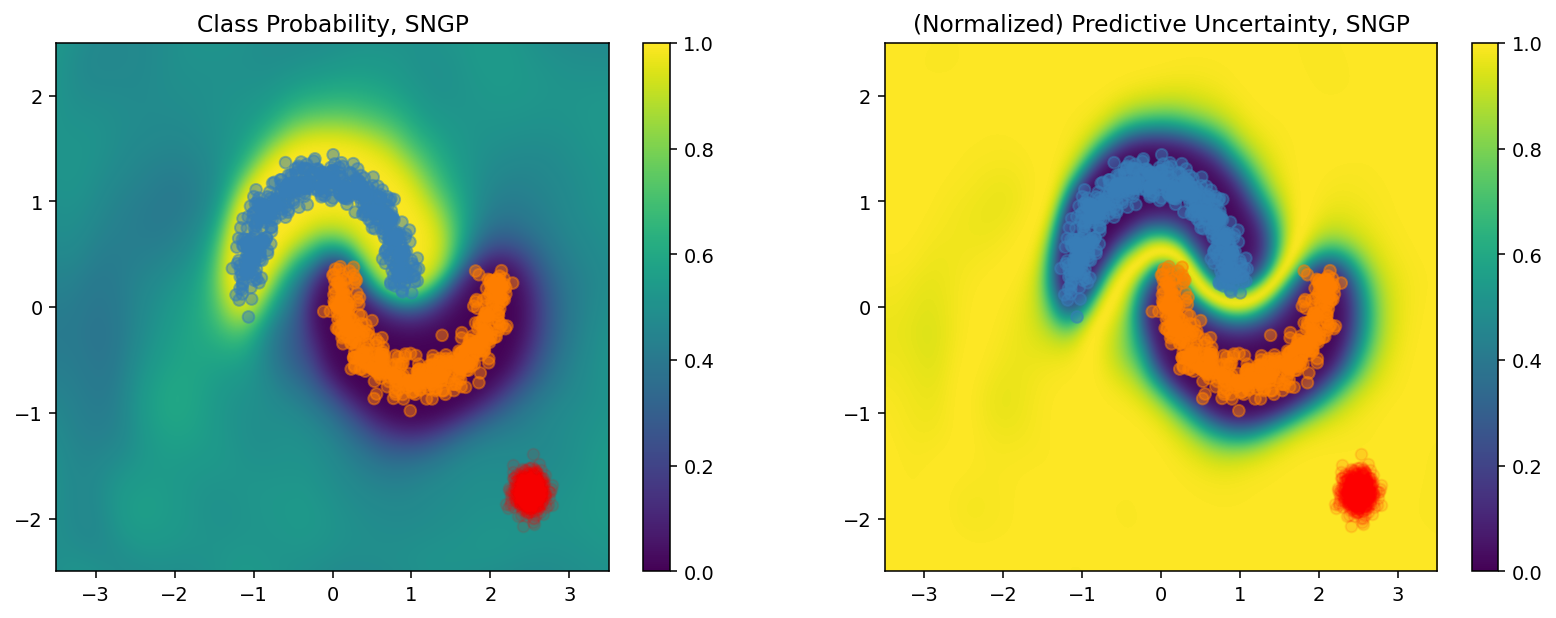

In [31]:
plot_predictions(sngp_probs, model_name="SNGP")

Remember that in the class probability plot (left), the yellow and purple are class probabilities. When close to the training data domain, SNGP correctly classifies the examples with high confidence (i.e., assigning near 0 or 1 probability). When far away from the training data, SNGP gradually becomes less confident, and its predictive probability becomes close to 0.5 while the (normalized) model uncertainty rises to 1.

Compare this to the uncertainty surface of the deterministic model: 

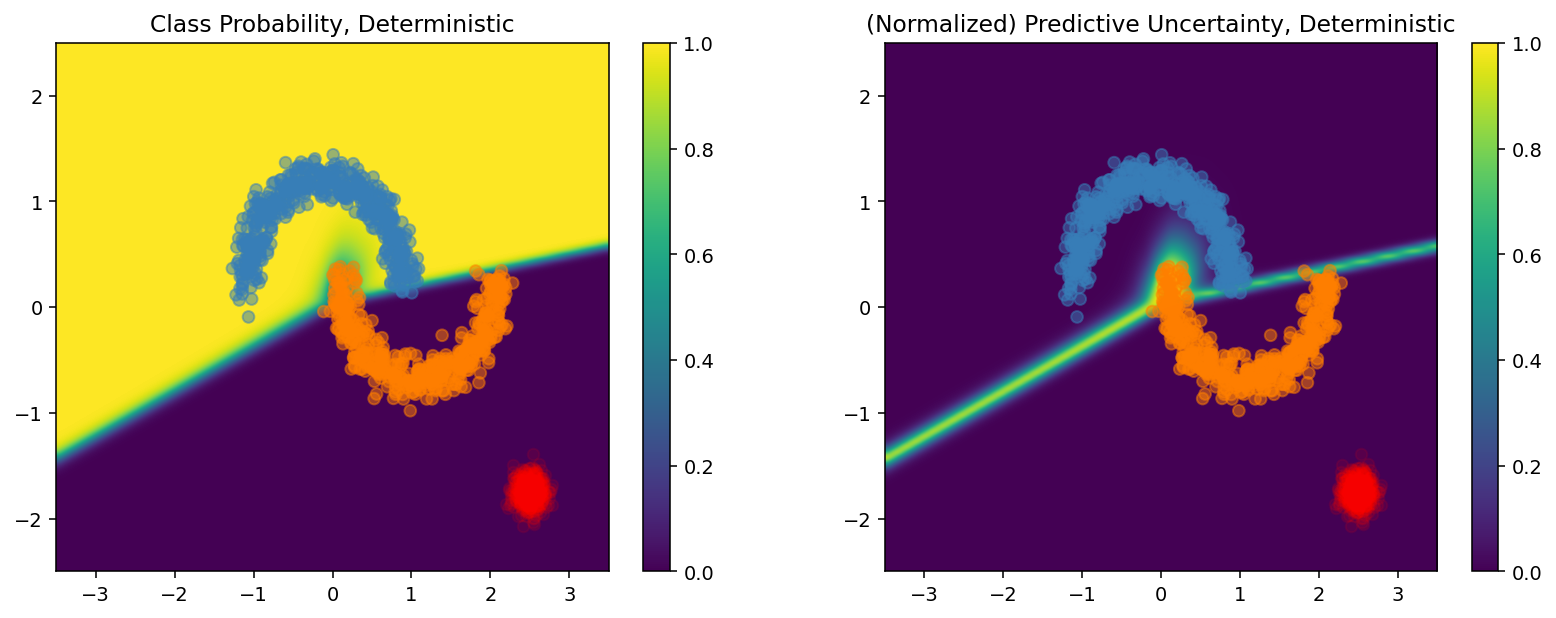

In [32]:
plot_predictions(resnet_probs[:, 0], model_name="Deterministic")

As mentioned earlier, a deterministic model is not _distance-aware_. Its uncertainty is defined by the distance of the test example from the decision boundary. This leads the model to produce overconfident predictions for the out-of-domain examples (red).